<font size="+3"><strong> Predicting Price with Size, Location, and Neighborhood</strong></font>

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


In the final lesson for this project, we're going to try to use all the features in our dataset to improve our model. This means that we'll have to do a more careful cleaning of the dataset and consider some of the finer points of linear models.

# Prepare Data

## Import

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # drop columns with high null counts
    df.drop(columns=["floor","expenses"],inplace=True)
    
    # drop columns with high and low cardinality
    df.drop(columns=["operation","property_type","currency","properati_url"],inplace=True)
    
    # drop leaky columns
    df.drop(columns=[
         'price',
         'price_aprox_local_currency',
         'price_per_m2',
         'price_usd_per_m2']
           ,inplace=True)
    
    # drop columns with multicollinearity
    df.drop(columns=['surface_total_in_m2','rooms'], inplace=True)
    return df

**Task 2.4.1:** Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory. Assign this list to the variable name `files`.


In [3]:
files = glob("data/buenos-aires-real-estate-[1-5].csv")
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

The last time we put all our DataFrames into a list, we used a `for` loop. This time, we're going to use a more compact coding technique called a **list comprehension**.  

**Task 2.4.2:** Use your `wrangle` function in a list comprehension to create a list named `frames`. The list should contain the cleaned DataFrames for the filenames your collected in `files`.


In [4]:
frames = [wrangle(file) for file in files]

**Task 2.4.3:** Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate it items in `frames` into a single DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

In [5]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


## Explore

The first thing we need to consider when trying to use all the features `df` is **missing values**. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from `df.info()` above. Are there columns where more than half of the values are `NaN`? If so, those columns need to go! 

**Task 2.4.4:** Modify your `wrangle` function to drop any columns that are more than half `NaN` values. Be sure to rerun all the cells above before you continue.


In [6]:
df.isnull().sum()/len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

The next thing we need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

**Task 2.4.5:** Calculate the number of unique values for each non-numeric feature in `df`.


In [7]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

Here, we can see that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

**Task 2.4.6:** Modify your `wrangle` function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.


It's also important for us to drop any columns that would constitute **leakage**, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed. 

**Task 2.4.7:** Modify your `wrangle` function to drop any features that would constitute leakage. 

Be sure to rerun all the cells above before you continue.


In [8]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

**Task 2.4.8:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"price_aprox_usd"` will be your target, you don't need to include it in your heatmap.
​

<AxesSubplot:>

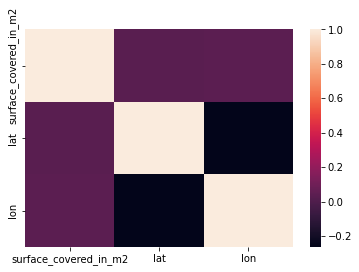

In [9]:
corr=df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

**Task 2.4.9:** Modify your `wrangle` function to remove columns so that there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.


## Split Data

**Task 2.4.10:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.


In [10]:
target = "price_aprox_usd"
feature= ["surface_covered_in_m2","lat","lon","neighborhood"]
X_train=df[feature]
y_train=df[target]

# Build Model

## Baseline

**Task 2.4.11:** Calculate the baseline mean absolute error for your model.


In [11]:
y_mean=y_train.mean()
print("Mean apt price:", y_mean)
y_pre_baseline=[y_mean]*len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train,y_pre_baseline))

Mean apt price: 132383.83701458527
Baseline MAE: 44860.10834274134


## Iterate

**Task 2.4.12:** Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

In [12]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

**Task 2.4.13:** Calculate the training mean absolute error for your predictions as compared to the true targets in `y_train`.


In [13]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 24207.10719033024


**Task 2.4.14:** Import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a list of predictions using your model. Then run the following cell to submit your predictions to the grader.

In [14]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

# Communicate Results

For this lesson, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model — in other words, use it in action. So let's look at two ways you might deploy this model. 

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output. 

**Task 2.4.15:** Create a function `make_prediction` that takes four arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns your model's prediction for an apartment price. 

In [15]:
def make_prediction(area, lat, lon, neighborhood):
    data={
        "surface_covered_in_m2":area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df=pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)
    return f"Predicted apartment price: ${prediction}"

Let's see if your function works. Run the cell below to find out!

In [16]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $[250775.11]'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

**Task 2.4.16:** Make interact widget , run the cell, and then adjust the widget to see how predicted apartment price changes. 

- Create an interact function in Jupyter Widgets.

In [17]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…